In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
    ])

transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=64,
                                          shuffle=True)

mnist_data_valid = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

data_loader_valid = torch.utils.data.DataLoader(dataset=mnist_data_valid,
                                          batch_size=64,
                                          shuffle=True)  

In [3]:
dataiter = iter(data_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [4]:
class Autoencoder_Linear(nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    

In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [6]:
def add_gaussian_noise(images, noise_factor=0.5):
    noisy = images + noise_factor * torch.randn_like(images)
    noisy = torch.clip(noisy, 0., 1.)
    return noisy

def downsample_images(images, target_size):
    return F.interpolate(images, size=(target_size, target_size), mode='bicubic', align_corners=False)


In [7]:
class SuperResolution7x7(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 1, 3, padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

class SuperResolution14x14(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, 3, padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [8]:
model_denoising = Autoencoder()
criterion = nn.MSELoss()
optimizer_dn = torch.optim.Adam(model_denoising.parameters(), lr=1e-3, weight_decay=1e-5)

num_epochs = 10
noise_factor = 0.5
outputs_denoising = []

for epoch in range(num_epochs):
    for (img, _) in data_loader:
        noisy_img = add_gaussian_noise(img, noise_factor)
        
        recon = model_denoising(noisy_img)
        loss = criterion(recon, img)
        
        optimizer_dn.zero_grad()
        loss.backward()
        optimizer_dn.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs_denoising.append((epoch, img, noisy_img, recon))


Epoch:1, Loss:0.0163
Epoch:2, Loss:0.0134
Epoch:3, Loss:0.0137
Epoch:4, Loss:0.0133
Epoch:5, Loss:0.0115
Epoch:6, Loss:0.0118
Epoch:7, Loss:0.0118
Epoch:8, Loss:0.0103
Epoch:9, Loss:0.0111
Epoch:10, Loss:0.0120


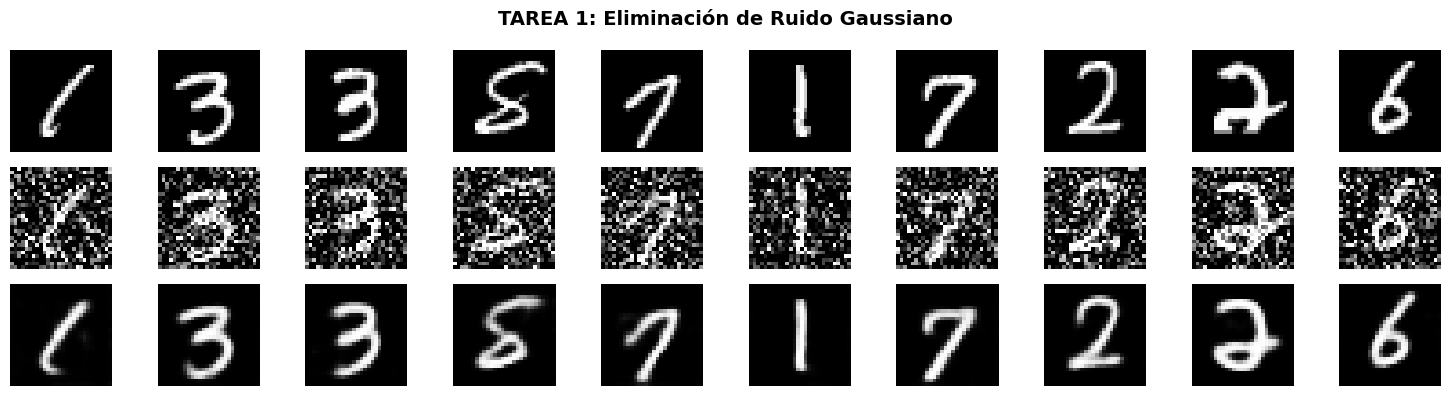

In [9]:
epoch, original, noisy, reconstructed = outputs_denoising[-1]
num_images = 10

plt.figure(figsize=(15, 4))
plt.suptitle('TAREA 1: Eliminación de Ruido Gaussiano', fontsize=14, fontweight='bold')
plt.gray()

for i in range(num_images):
    plt.subplot(3, num_images, i+1)
    plt.imshow(original[i].squeeze())
    plt.axis('off')
    if i == 0:
        plt.ylabel('Original\n(Real)', fontsize=11, fontweight='bold')
    
    plt.subplot(3, num_images, num_images+i+1)
    plt.imshow(noisy[i].squeeze())
    plt.axis('off')
    if i == 0:
        plt.ylabel('Con Ruido\n(Entrada)', fontsize=11, fontweight='bold')
    
    plt.subplot(3, num_images, 2*num_images+i+1)
    plt.imshow(reconstructed[i].detach().squeeze())
    plt.axis('off')
    if i == 0:
        plt.ylabel('Reconstruida\n(Salida)', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


In [10]:
model_sr7 = SuperResolution7x7()
criterion = nn.MSELoss()
optimizer_sr7 = torch.optim.Adam(model_sr7.parameters(), lr=1e-3, weight_decay=1e-5)

num_epochs = 15
outputs_sr7 = []

for epoch in range(num_epochs):
    for (img, _) in data_loader:
        img_7x7 = downsample_images(img, 7)
        
        recon = model_sr7(img_7x7)
        loss = criterion(recon, img)
        
        optimizer_sr7.zero_grad()
        loss.backward()
        optimizer_sr7.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs_sr7.append((epoch, img, img_7x7, recon))


Epoch:1, Loss:0.1160
Epoch:2, Loss:0.1098
Epoch:3, Loss:0.1028
Epoch:4, Loss:0.0317
Epoch:5, Loss:0.0226
Epoch:6, Loss:0.0185
Epoch:7, Loss:0.0182
Epoch:8, Loss:0.0162
Epoch:9, Loss:0.0163
Epoch:10, Loss:0.0127
Epoch:11, Loss:0.0175
Epoch:12, Loss:0.0136
Epoch:13, Loss:0.0160
Epoch:14, Loss:0.0141
Epoch:15, Loss:0.0122


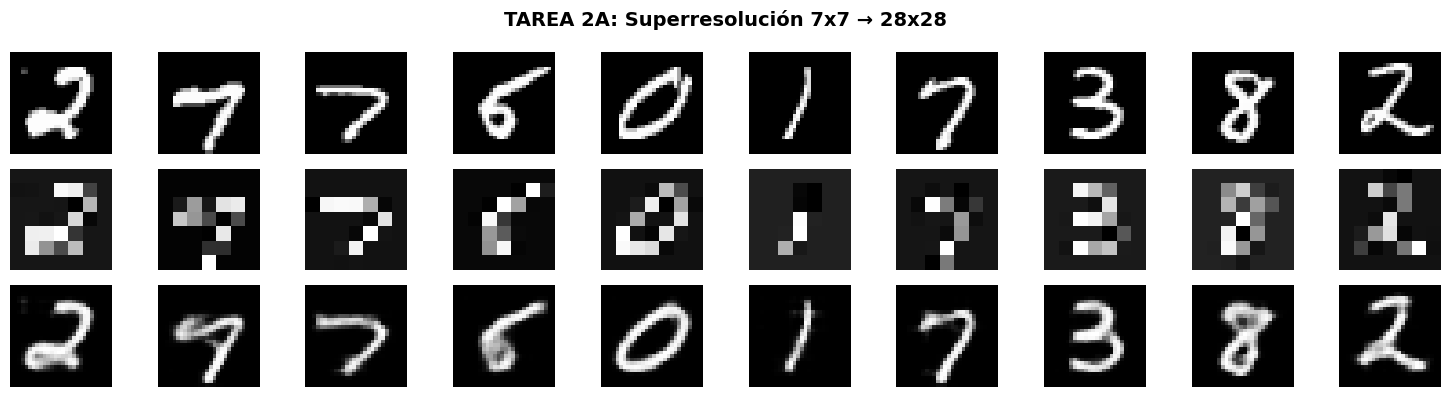

In [11]:
epoch, original, low_res, reconstructed = outputs_sr7[-1]
num_images = 10

plt.figure(figsize=(15, 4))
plt.suptitle('TAREA 2A: Superresolución 7x7 → 28x28', fontsize=14, fontweight='bold')
plt.gray()

for i in range(num_images):
    plt.subplot(3, num_images, i+1)
    plt.imshow(original[i].squeeze())
    plt.axis('off')
    if i == 0:
        plt.ylabel('Original\n(28x28)', fontsize=11, fontweight='bold')
    
    plt.subplot(3, num_images, num_images+i+1)
    plt.imshow(low_res[i].squeeze())
    plt.axis('off')
    if i == 0:
        plt.ylabel('Reducida\n(7x7)', fontsize=11, fontweight='bold')
    
    plt.subplot(3, num_images, 2*num_images+i+1)
    plt.imshow(reconstructed[i].detach().squeeze())
    plt.axis('off')
    if i == 0:
        plt.ylabel('Generada\n(28x28)', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


In [12]:
model_sr14 = SuperResolution14x14()
optimizer_sr14 = torch.optim.Adam(model_sr14.parameters(), lr=1e-3, weight_decay=1e-5)

num_epochs = 15
outputs_sr14 = []

for epoch in range(num_epochs):
    for (img, _) in data_loader:
        img_14x14 = downsample_images(img, 14)
        
        recon = model_sr14(img_14x14)
        loss = criterion(recon, img)
        
        optimizer_sr14.zero_grad()
        loss.backward()
        optimizer_sr14.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs_sr14.append((epoch, img, img_14x14, recon))


Epoch:1, Loss:0.0021
Epoch:2, Loss:0.0021
Epoch:3, Loss:0.0016
Epoch:4, Loss:0.0018
Epoch:5, Loss:0.0014
Epoch:6, Loss:0.0017
Epoch:7, Loss:0.0017
Epoch:8, Loss:0.0017
Epoch:9, Loss:0.0018
Epoch:10, Loss:0.0016
Epoch:11, Loss:0.0014
Epoch:12, Loss:0.0014
Epoch:13, Loss:0.0014
Epoch:14, Loss:0.0014
Epoch:15, Loss:0.0012


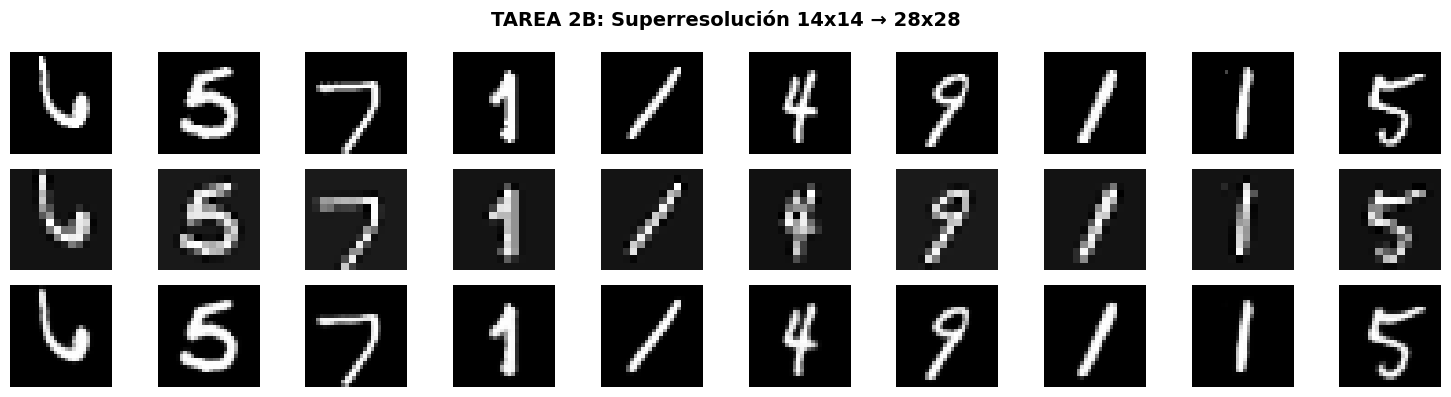

In [13]:
epoch, original, low_res, reconstructed = outputs_sr14[-1]
num_images = 10

plt.figure(figsize=(15, 4))
plt.suptitle('TAREA 2B: Superresolución 14x14 → 28x28', fontsize=14, fontweight='bold')
plt.gray()

for i in range(num_images):
    plt.subplot(3, num_images, i+1)
    plt.imshow(original[i].squeeze())
    plt.axis('off')
    if i == 0:
        plt.ylabel('Original\n(28x28)', fontsize=11, fontweight='bold')
    
    plt.subplot(3, num_images, num_images+i+1)
    plt.imshow(low_res[i].squeeze())
    plt.axis('off')
    if i == 0:
        plt.ylabel('Reducida\n(14x14)', fontsize=11, fontweight='bold')
    
    plt.subplot(3, num_images, 2*num_images+i+1)
    plt.imshow(reconstructed[i].detach().squeeze())
    plt.axis('off')
    if i == 0:
        plt.ylabel('Generada\n(28x28)', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()
